In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [4]:
# Set style for visualizations (updated to use valid style)
plt.style.use('ggplot')  # Using 'ggplot' style which is widely available
sns.set_style("whitegrid")
sns.set_palette("husl")

In [12]:
# 1. Load and Prepare Data
df = pd.read_csv(r"C:\Users\ASUS\Downloads\cleaned_kaggle_data.csv")


In [14]:
# Convert target to binary (1 = No-show, 0 = Show)
df['No-show'] = df['No-show'].map({'Yes': 1, 'No': 0})


In [16]:
# 2. Feature Selection and Engineering
features = ['Gender', 'Age', 'Scholarship', 'Hipertension', 'Diabetes', 
            'Alcoholism', 'SMS_received', 'DaysBetween', 'ScheduledHour',
            'AppointmentDOW', 'AgeGroup']


In [38]:
# Convert all numeric columns to float type explicitly
numeric_cols = ['Age', 'Scholarship', 'Hipertension', 'Diabetes', 
               'Alcoholism', 'SMS_received', 'DaysBetween', 'ScheduledHour']
df[numeric_cols] = df[numeric_cols].astype(float)

In [40]:
X = pd.get_dummies(df[features], drop_first=True)
y = df['No-show']


In [42]:
# Verify no object dtypes remain
print("\n=== Data Types Check ===")
print(X.dtypes)



=== Data Types Check ===
Age                         float64
Scholarship                 float64
Hipertension                float64
Diabetes                    float64
Alcoholism                  float64
SMS_received                float64
DaysBetween                 float64
ScheduledHour               float64
Gender_M                       bool
AppointmentDOW_Monday          bool
AppointmentDOW_Saturday        bool
AppointmentDOW_Thursday        bool
AppointmentDOW_Tuesday         bool
AppointmentDOW_Wednesday       bool
AgeGroup_19-35                 bool
AgeGroup_36-55                 bool
AgeGroup_56-75                 bool
AgeGroup_75+                   bool
dtype: object


In [20]:
# 3. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [22]:
# 4. Feature Scaling
scaler = StandardScaler()
num_cols = ['Age', 'DaysBetween', 'ScheduledHour']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


In [24]:
# 5. Logistic Regression Model (scikit-learn)
logreg = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
logreg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [26]:
# 6. Model Evaluation
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]


In [28]:
print("=== Model Evaluation ===")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

=== Model Evaluation ===

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.69      0.77     26475
           1       0.32      0.58      0.41      6682

    accuracy                           0.67     33157
   macro avg       0.59      0.63      0.59     33157
weighted avg       0.76      0.67      0.69     33157


Confusion Matrix:
[[18186  8289]
 [ 2811  3871]]

ROC AUC Score: 0.668562026884907


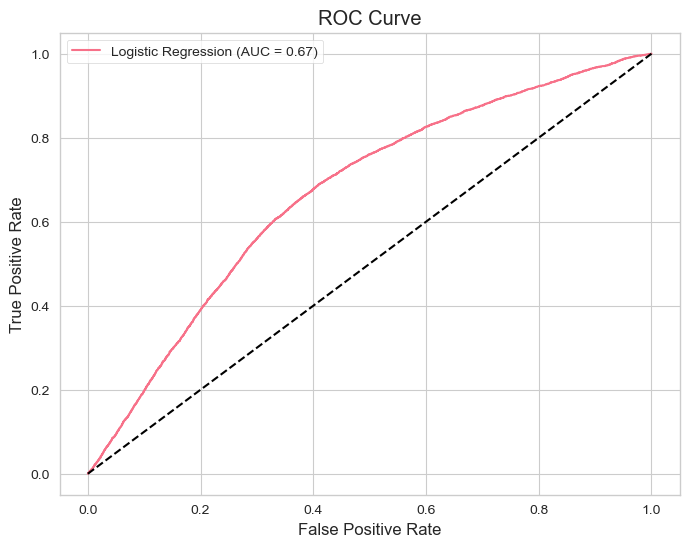

In [30]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [32]:
# 7. Feature Importance Analysis
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': logreg.coef_[0],
    'Abs_Coefficient': abs(logreg.coef_[0]),
    'Odds_Ratio': np.exp(logreg.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("\n=== Feature Importance ===")
print(feature_importance[['Feature', 'Coefficient', 'Odds_Ratio']])



=== Feature Importance ===
                     Feature  Coefficient  Odds_Ratio
16            AgeGroup_56-75    -0.518526    0.595398
17              AgeGroup_75+    -0.511917    0.599345
6                DaysBetween     0.419805    1.521664
5               SMS_received     0.381217    1.464065
1                Scholarship     0.218852    1.244647
15            AgeGroup_36-55    -0.201242    0.817715
12    AppointmentDOW_Tuesday    -0.182528    0.833162
4                 Alcoholism     0.177916    1.194724
10   AppointmentDOW_Saturday     0.171294    1.186840
13  AppointmentDOW_Wednesday    -0.167095    0.846119
3                   Diabetes     0.162179    1.176071
11   AppointmentDOW_Thursday    -0.161708    0.850690
7              ScheduledHour     0.118137    1.125398
9      AppointmentDOW_Monday    -0.116397    0.890122
14            AgeGroup_19-35     0.072492    1.075184
2               Hipertension     0.021372    1.021602
8                   Gender_M     0.021242    1.021470


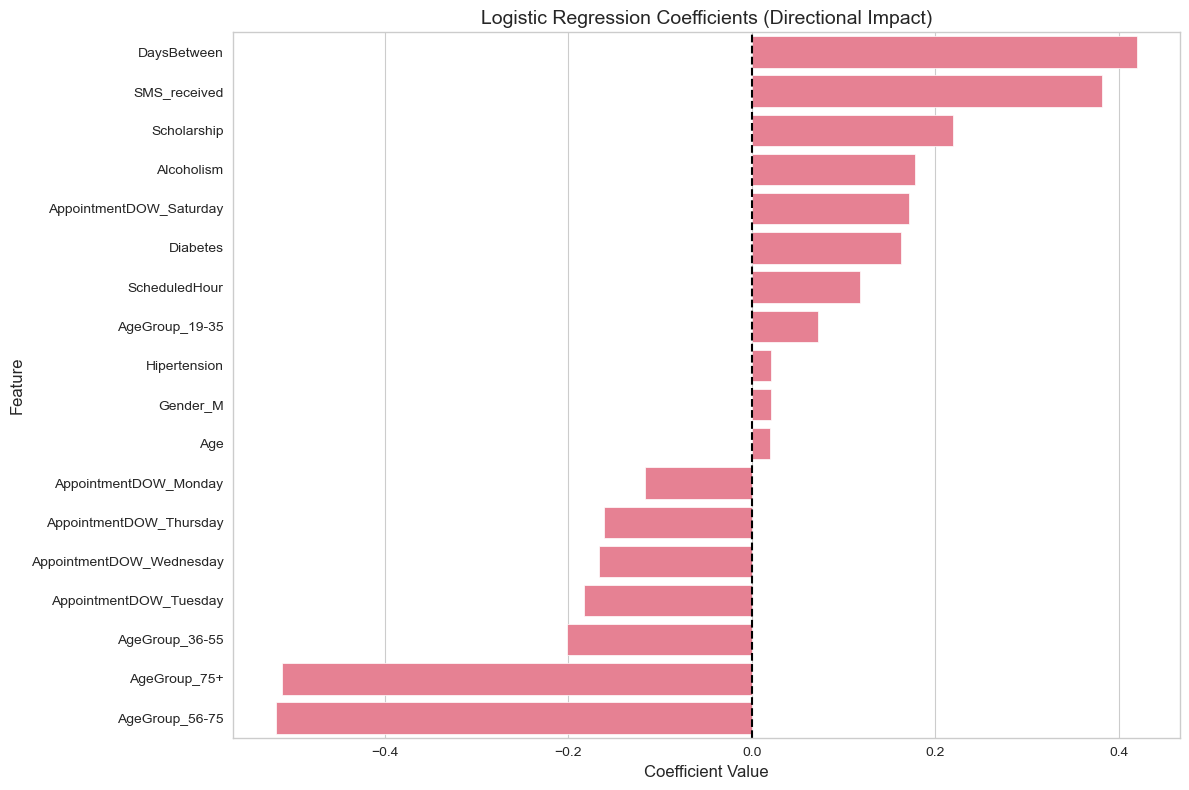

In [46]:
# 9. Visualizing Feature Importance
plt.figure(figsize=(12,8))
sns.barplot(x='Coefficient', y='Feature', 
            data=feature_importance.sort_values('Coefficient', ascending=False))
plt.title('Logistic Regression Coefficients (Directional Impact)', fontsize=14)
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.axvline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

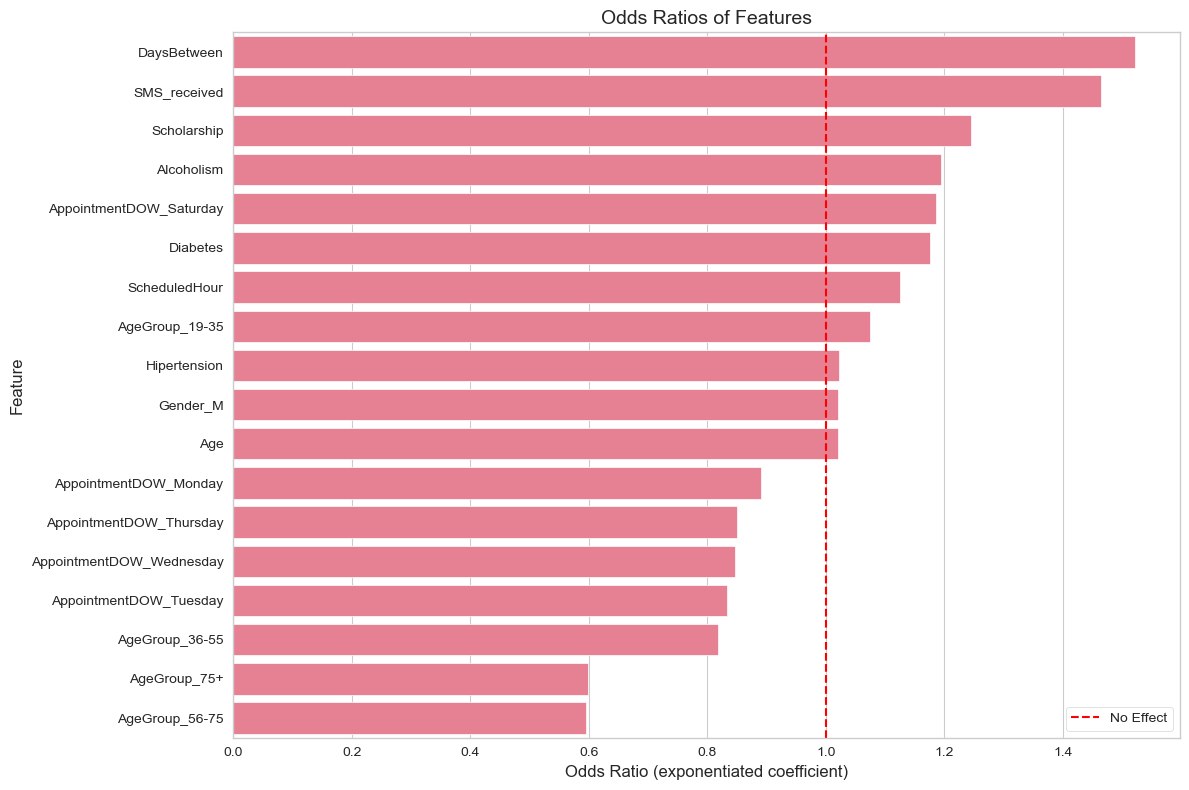

In [48]:
plt.figure(figsize=(12,8))
sns.barplot(x='Odds_Ratio', y='Feature', 
            data=feature_importance.sort_values('Odds_Ratio', ascending=False))
plt.title('Odds Ratios of Features', fontsize=14)
plt.xlabel('Odds Ratio (exponentiated coefficient)', fontsize=12)
plt.axvline(1, color='red', linestyle='--', label='No Effect')
plt.ylabel('Feature', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

In [50]:
# 10. Practical Impact Analysis
print("\n=== Practical Impact Analysis ===")
print("How features change probability of no-show (baseline = 20% probability):")



=== Practical Impact Analysis ===
How features change probability of no-show (baseline = 20% probability):


In [60]:
baseline_prob = 0.20
for feature in feature_importance['Feature'].head(5):
    coef = feature_importance.loc[feature_importance['Feature'] == feature, 'Coefficient'].values[0]
    odds_ratio = np.exp(coef)
      # Calculate probability change for one unit increase
    new_odds = (baseline_prob/(1-baseline_prob)) * odds_ratio
    new_prob = new_odds / (1 + new_odds)
    change = (new_prob - baseline_prob)*100
    direction = "increases" if coef > 0 else "decreases"
    print(f"{feature}: {direction} no-show probability by {abs(change):.1f}% (OR: {odds_ratio:.2f})")
    

AgeGroup_56-75: decreases no-show probability by 7.0% (OR: 0.60)
AgeGroup_75+: decreases no-show probability by 7.0% (OR: 0.60)
DaysBetween: increases no-show probability by 7.6% (OR: 1.52)
SMS_received: increases no-show probability by 6.8% (OR: 1.46)
Scholarship: increases no-show probability by 3.7% (OR: 1.24)
